In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
num_points = 300

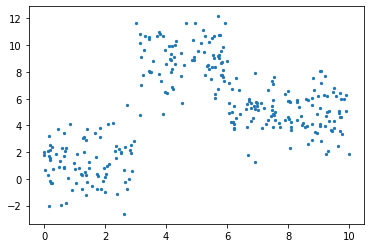

In [55]:
def f(x):
    mu, sigma = 0, 1.5
    if x < 3: return 1 + np.random.normal(mu, sigma, 1)
    elif x >= 3 and x < 6: return 9 + np.random.normal(mu, sigma, 1)
    elif x >= 6: return 5 + np.random.normal(mu, sigma, 1)
    
np.random.seed(1)
    
x = np.random.uniform(0, 10, num_points)
y = np.array( [f(i) for i in x] )

plt.scatter(x, y, s = 5)

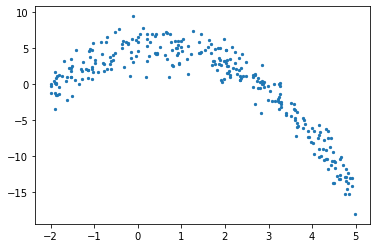

In [83]:
def f(x):
    mu, sigma = 0, 1.5
    return -x**2 + x + 5 + np.random.normal(mu, sigma, 1)

np.random.seed(1)
    
x = np.random.uniform(-2, 5, num_points)
y = np.array( [f(i) for i in x] )

plt.scatter(x, y, s = 5)

In [96]:
def SSR(r, y): #send numpy array
    return np.sum( (r - y)**2 )

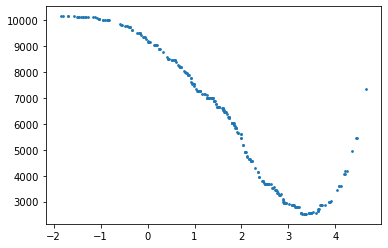

In [98]:
SSRs, thresholds = [], []
for i in range(len(x) - 1):
    threshold = x[i:i+2].mean()
    
    low = np.take(y, np.where(x < threshold))
    high = np.take(y, np.where(x > threshold))
    
    guess_low = low.mean()
    guess_high = high.mean()
    
    SSRs.append(SSR(low, guess_low) + SSR(high, guess_high))
    thresholds.append(threshold)
    
plt.scatter(thresholds, SSRs, s = 3)
plt.show()

In [99]:
print('Minimum residual is: {:.2f}\nCorresponding threshold value is: {:.4f}'.format(min(SSRs), 
                                                                                     thresholds[SSRs.index(min(SSRs))]))

Minimum residual is: 2527.33
Corresponding threshold value is: 3.3239


In [110]:
df = pd.DataFrame(zip(x, y.squeeze()), columns = ['x', 'y'])

In [154]:
def find_threshold(df, plot = False):
    SSRs, thresholds, pred_lows, pred_highs = [], [], [], []
    for i in range(len(df) - 1):
        threshold = df.x[i:i+2].mean()

        low = df[(df.x <= threshold)]
        high = df[(df.x > threshold)]

        guess_low = low.y.mean()
        guess_high = high.y.mean()
        
        pred_lows.append(guess_low)
        pred_highs.append(guess_high)

        SSRs.append(SSR(low.y.to_numpy(), guess_low) + SSR(high.y.to_numpy(), guess_high))
        thresholds.append(threshold)
    
    if plot:
        plt.scatter(thresholds, SSRs, s = 3)
        plt.show()
        
    return thresholds[SSRs.index(min(SSRs))], pred_lows[SSRs.index(min(SSRs))], pred_highs[SSRs.index(min(SSRs))]

In [117]:
class TreeNode():
    def __init__(self, threshold, df):
        self.threshold = threshold
        self.children = []
        self.df = df
        
tree = TreeNode(find_threshold(df), df)

def create_children(tree):
    #return if there are already 2 children
    if len(tree.children) == 2:
        return
    #if there is 1 children, start high part
    if len(tree.children) == 1:
        high = tree.df[tree.df.x > tree.threshold]
        if len(high) > 5: 
            high_tree = TreeNode(find_threshold(high), high)
            tree.children.append(high_tree)
        else:
            tree.children.append([])
    #if there is no children, start with low part
    if len(tree.children) == 0:
        low = tree.df[tree.df.x <= tree.threshold]
        if len(low) > 5: 
            low_tree = TreeNode(find_threshold(low), low)
            tree.children.append(low_tree)
        else:
            tree.children.append([])
            
def create_nodes(tree):
    if len(tree.df) <= 5:
        return
    while len(tree.children) < 2:
        create_children(tree)
        
        try:
            if len(tree.children) != 0: #if there is any children
                create_nodes(tree.children[-1]) #create its nodes
        except:
            pass
            
create_nodes(tree)
tree

In [149]:
def predict(x):
    curr_node = tree
    while True:
        if x <= curr_node.threshold:
            if curr_node.children[0]: curr_node = curr_node.children[0]
            else: break
        elif x > curr_node.threshold:
            if curr_node.children[1]: curr_node = curr_node.children[1]
            else: break
    return curr_node.df.y.mean()
    
predict(5)

AttributeError: 'TreeNode' object has no attribute 'children'

In [160]:
class TreeNode():
    def __init__(self, threshold, low, high):
        self.threshold = threshold
        self.pred_low = low
        self.pred_high = high
        self.left = None
        self.right = None

def create_nodes(tree, df, stop):
    low = df[df.x <= tree.threshold]
    high = df[df.x > tree.threshold]
    
    if len(low) > stop:
        threshold, low_guess, high_guess = find_threshold(low)
        tree.left = TreeNode(threshold, low_guess, high_guess)
        create_nodes(tree.left, low, stop)
        
    if len(high) > stop:
        threshold, low_guess, high_guess = find_threshold(high)
        tree.right = TreeNode(threshold, low_guess, high_guess)
        create_nodes(tree.right, high, stop)
        
threshold, low_guess, high_guess = find_threshold(df)
tree = TreeNode(threshold, low_guess, high_guess)

create_nodes(tree, df, 5)

In [185]:
def predict(x):
    curr_node = tree
    result = None
    while True:
        if x <= curr_node.threshold:
            if curr_node.left: 
                curr_node = curr_node.left
            else: 
                result = curr_node.pred_low
                break
        elif x > curr_node.threshold:
            if curr_node.right: curr_node = curr_node.right
            else: 
                result = curr_node.pred_high
                break
    return result
    
predict(4)

-7.3940384890057915

In [179]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

preds = np.array( [predict(i) for i in df.x] )
RSE(df.y, preds)

0.03576193606243211